In [ ]:
import os
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import seaborn as sns

from sklearn.metrics import confusion_matrix, accuracy_score
from torchsummary import summary
from torchvision import models, transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [ ]:
!kaggle datasets download -d utkarshsaxenadn/fast-food-classification-dataset
!unzip fast-food-classification-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: Fast Food Classification V2/Train/Taquito/Taquito-Train (1).jpeg  
  inflating: Fast Food Classification V2/Train/Taquito/Taquito-Train (10).jpeg  
  inflating: Fast Food Classification V2/Train/Taquito/Taquito-Train (100).jpeg  
  inflating: Fast Food Classification V2/Train/Taquito/Taquito-Train (1000).jpeg  
  inflating: Fast Food Classification V2/Train/Taquito/Taquito-Train (1001).jpeg  
  inflating: Fast Food Classification V2/Train/Taquito/Taquito-Train (1002).jpeg  
  inflating: Fast Food Classification V2/Train/Taquito/Taquito-Train (1003).jpeg  
  inflating: Fast Food Classification V2/Train/Taquito/Taquito-Train (1004).jpeg  
  inflating: Fast Food Classification V2/Train/Taquito/Taquito-Train (1005).jpeg  
  inflating: Fast Food Classification V2/Train/Taquito/Taquito-Train (1006).jpeg  
  inflating: Fast Food Classification V2/Train/Taquito/Taquito-Train (1007).jpeg  
  inflating: Fast Food Classification V2/T

**Load Datasets**

In [ ]:
# Custom Dataset for Loading Images
class CustomImageDataset(Dataset):
    def __init__(self, directory, transform=None):
        self.directory = directory
        self.transform = transform
        self.images = []
        self.labels = []
        self.class_names = sorted(os.listdir(directory))  # Sorted for consistent labels
        self.class_to_index = {class_name: i for i, class_name in enumerate(self.class_names)}

        for class_name in self.class_names:
            class_path = os.path.join(directory, class_name)
            if os.path.isdir(class_path):
                for img_name in os.listdir(class_path):
                    img_path = os.path.join(class_path, img_name)
                    try:
                        image = Image.open(img_path).convert('RGB')
                        self.images.append((image, self.class_to_index[class_name]))  # Append (image, label)
                    except Exception as e:
                        print(f"Error loading image {img_name}: {e}")

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image, label = self.images[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

# Data Augmentation and Preprocessing
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Transformations for ResNet input
transform_val = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet normalization
])

In [ ]:
# Directory setup
dataset_dir = '/content/Fast Food Classification V2'
train_dir = os.path.join(dataset_dir, 'Train')
valid_dir = os.path.join(dataset_dir, 'Valid')

In [ ]:
# Create Datasets and Loaders
train_dataset = CustomImageDataset(train_dir, transform=transform_train)
valid_dataset = CustomImageDataset(valid_dir, transform=transform_val)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32)

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [ ]:
# Check the class distribution
class_counts = {class_name: 0 for class_name in train_dataset.class_names}
for _, label in train_dataset.images:
    class_counts[train_dataset.class_names[label]] += 1

print("Class distribution in the training dataset:")
print(class_counts)


Class distribution in the training dataset:
{'Baked Potato': 1500, 'Burger': 1500, 'Crispy Chicken': 1500, 'Donut': 1500, 'Fries': 1500, 'Hot Dog': 1500, 'Pizza': 1500, 'Sandwich': 1500, 'Taco': 1500, 'Taquito': 1500}


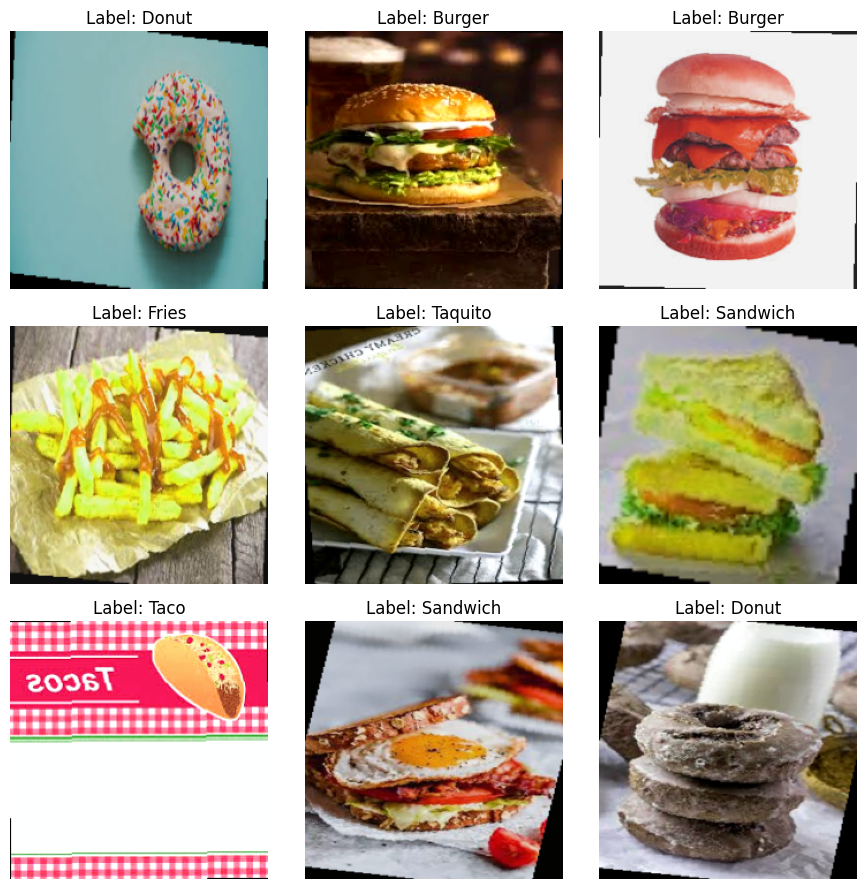

In [ ]:
# Visualize some random samples from the training set
random_indices = random.sample(range(len(train_dataset)), 9)
fig, axes = plt.subplots(3, 3, figsize=(9, 9))
axes = axes.flatten()

for ax, index in zip(axes, random_indices):
    image, label = train_dataset[index]
    image = image.permute(1, 2, 0).numpy()
    image = np.clip(image * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406]), 0, 1)
    ax.imshow(image)
    ax.set_title(f'Label: {train_dataset.class_names[label]}')
    ax.axis('off')

plt.tight_layout()
plt.show()

**Resnet 50**

In [ ]:
resnet_model = models.resnet50(weights='IMAGENET1K_V1').cuda()

In [ ]:
for n,p in resnet_model.named_parameters():
  print(n)

conv1.weight
bn1.weight
bn1.bias
layer1.0.conv1.weight
layer1.0.bn1.weight
layer1.0.bn1.bias
layer1.0.conv2.weight
layer1.0.bn2.weight
layer1.0.bn2.bias
layer1.0.conv3.weight
layer1.0.bn3.weight
layer1.0.bn3.bias
layer1.0.downsample.0.weight
layer1.0.downsample.1.weight
layer1.0.downsample.1.bias
layer1.1.conv1.weight
layer1.1.bn1.weight
layer1.1.bn1.bias
layer1.1.conv2.weight
layer1.1.bn2.weight
layer1.1.bn2.bias
layer1.1.conv3.weight
layer1.1.bn3.weight
layer1.1.bn3.bias
layer1.2.conv1.weight
layer1.2.bn1.weight
layer1.2.bn1.bias
layer1.2.conv2.weight
layer1.2.bn2.weight
layer1.2.bn2.bias
layer1.2.conv3.weight
layer1.2.bn3.weight
layer1.2.bn3.bias
layer2.0.conv1.weight
layer2.0.bn1.weight
layer2.0.bn1.bias
layer2.0.conv2.weight
layer2.0.bn2.weight
layer2.0.bn2.bias
layer2.0.conv3.weight
layer2.0.bn3.weight
layer2.0.bn3.bias
layer2.0.downsample.0.weight
layer2.0.downsample.1.weight
layer2.0.downsample.1.bias
layer2.1.conv1.weight
layer2.1.bn1.weight
layer2.1.bn1.bias
layer2.1.conv2.we

In [ ]:
# Freeze all layers
for param in resnet_model.parameters():
    param.requires_grad = False

In [ ]:
for param in resnet_model.layer4.parameters():
    param.requires_grad = True

for param in resnet_model.layer3.parameters():
    param.requires_grad = True

In [ ]:
summary(resnet_model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

In [ ]:
# Modify the final layer to match the number of classes
num_classes = len(train_dataset.class_names)
resnet_model.fc = nn.Sequential(
    nn.Linear(resnet_model.fc.in_features, 256),  # Add intermediate layer
    nn.ReLU(),
    nn.Dropout(0.5),  # Dropout to prevent overfitting
    nn.Linear(256, num_classes)
).cuda()

In [ ]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss().cuda()
optimizer = optim.Adam(resnet_model.fc.parameters(), lr=0.0001)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)

In [ ]:
# Early stopping parameters
best_val_loss = float('inf')
early_stopping_patience = 5
no_improvement_epochs = 0

**Result**

In [ ]:
# Training Loop
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
num_epochs = 50

for epoch in range(num_epochs):
    resnet_model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.cuda(), labels.cuda()

        optimizer.zero_grad()  # Zero gradients

        outputs = resnet_model(images)  # Forward pass
        loss = criterion(outputs, labels)  # Compute loss

        loss.backward()  # Backward pass
        optimizer.step()  # Update model parameters

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    accuracy = 100 * correct / total
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {accuracy:.2f}%")

    # Store training loss and accuracy
    train_losses.append(epoch_loss)
    train_accuracies.append(accuracy)

    # Validation Loop
    resnet_model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in valid_loader:
            images, labels = images.cuda(), labels.cuda()

            outputs = resnet_model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss /= len(valid_loader)
    val_accuracy = 100 * correct / total
    print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%')

    # Store validation loss and accuracy
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    # Learning rate scheduler
    scheduler.step(val_loss)

    # Early Stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        no_improvement_epochs = 0
    else:
        no_improvement_epochs += 1
        if no_improvement_epochs >= early_stopping_patience:
            print("Early stopping triggered!")
            break

Epoch [1/50], Loss: 1.6015, Accuracy: 52.23%
Validation Loss: 1.0848, Validation Accuracy: 70.57%
Epoch [2/50], Loss: 1.0800, Accuracy: 67.27%
Validation Loss: 0.8705, Validation Accuracy: 75.40%
Epoch [3/50], Loss: 0.9444, Accuracy: 70.70%
Validation Loss: 0.8377, Validation Accuracy: 74.46%
Epoch [4/50], Loss: 0.8941, Accuracy: 72.05%
Validation Loss: 0.7902, Validation Accuracy: 75.74%
Epoch [5/50], Loss: 0.8515, Accuracy: 73.11%
Validation Loss: 0.7538, Validation Accuracy: 76.69%
Epoch [6/50], Loss: 0.8262, Accuracy: 74.09%
Validation Loss: 0.7508, Validation Accuracy: 77.11%
Epoch [7/50], Loss: 0.7999, Accuracy: 74.67%
Validation Loss: 0.7463, Validation Accuracy: 76.97%
Epoch [8/50], Loss: 0.7985, Accuracy: 74.59%
Validation Loss: 0.7355, Validation Accuracy: 77.83%
Epoch [9/50], Loss: 0.7859, Accuracy: 75.04%
Validation Loss: 0.7097, Validation Accuracy: 78.60%
Epoch [10/50], Loss: 0.7843, Accuracy: 75.20%
Validation Loss: 0.6988, Validation Accuracy: 78.43%
Epoch [11/50], Loss

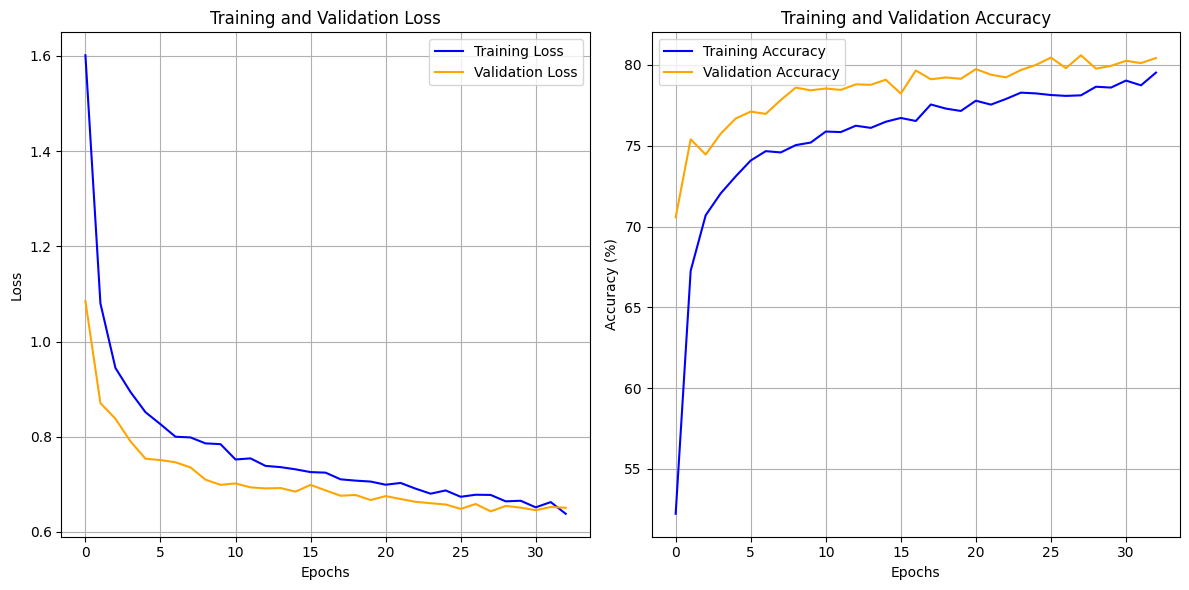

In [ ]:
# Plotting training and validation loss and accuracy
plt.figure(figsize=(12, 6))

# Plot training and validation loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss', color='blue')
plt.plot(val_losses, label='Validation Loss', color='orange')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy', color='blue')
plt.plot(val_accuracies, label='Validation Accuracy', color='orange')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

In [ ]:
def predict(image_path, resnet_model, transform_val, class_names):

  try:
    image = Image.open(image_path).convert('RGB')
    image = transform_val(image).unsqueeze(0).cuda()

    resnet_model.eval()
    with torch.no_grad():
      output = resnet_model(image)
      _, predicted = torch.max(output, 1)

    predicted_class_index = predicted.item()
    predicted_class_name = class_names[predicted_class_index]

    return predicted_class_name

  except Exception as e:
    print(f"Error predicting image: {e}")
    return None


image_path_to_predict = '/content/7ef9fdf418cef2e8df51ad1b0f360bbf (1).jpg'  # Replace with your image path
predicted_class = predict(image_path_to_predict, resnet_model, transform_val, train_dataset.class_names)
if predicted_class:
  print(f"The predicted class for the image is: {predicted_class}")

The predicted class for the image is: Hot Dog


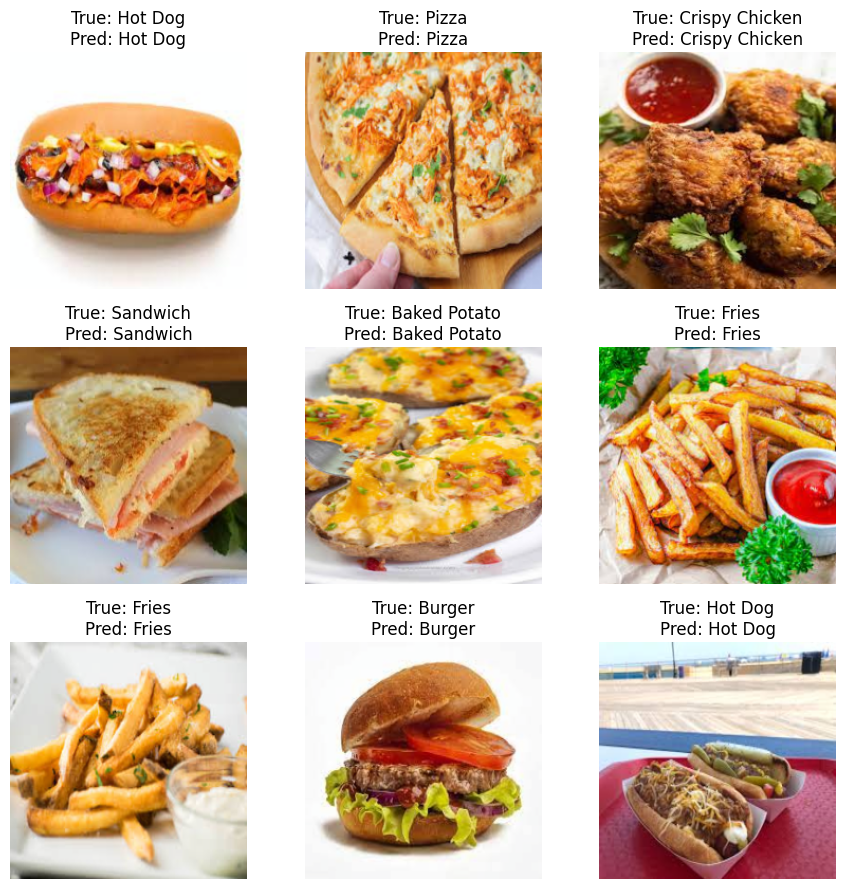

Test Accuracy: 82.53%


In [ ]:
test_dir = os.path.join(dataset_dir, 'Test')
test_dataset = CustomImageDataset(test_dir, transform=transform_val)
test_loader = DataLoader(test_dataset, batch_size=32)

# Prediction function
def predict_images(model, loader, class_names):
    resnet_model.eval()
    predictions = []
    true_labels = []
    images_list = []

    with torch.no_grad():  # Disable gradient computation for inference
        for images, labels in loader:
            images, labels = images.cuda(), labels.cuda()
            outputs = model(images)  # Forward pass

            _, predicted = torch.max(outputs, 1)  # Get the index of the highest probability class
            predictions.extend(predicted.cpu().numpy())  # Store the predictions
            true_labels.extend(labels.cpu().numpy())  # Store the true labels
            images_list.extend(images.cpu())  # Store the images for visualization

    return predictions, true_labels, images_list

# Call the prediction function
predictions, true_labels, test_images = predict_images(resnet_model, test_loader, test_dataset.class_names)

# Show a few test images with predicted labels
num_samples_to_show = 9
random_indices = random.sample(range(len(test_images)), num_samples_to_show)

fig, axes = plt.subplots(3, 3, figsize=(9, 9))
axes = axes.flatten()

for ax, idx in zip(axes, random_indices):
    image = test_images[idx]
    image = image.permute(1, 2, 0).numpy()  # Convert tensor to numpy format
    image = np.clip(image * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406]), 0, 1)  # Unnormalize

    true_label = true_labels[idx]
    predicted_label = predictions[idx]

    ax.imshow(image)
    ax.set_title(f"True: {test_dataset.class_names[true_label]}\nPred: {test_dataset.class_names[predicted_label]}")
    ax.axis('off')

plt.tight_layout()
plt.show()

# Calculate and print accuracy on the test set
correct_predictions = sum([1 if p == t else 0 for p, t in zip(predictions, true_labels)])
test_accuracy = correct_predictions / len(true_labels) * 100
print(f"Test Accuracy: {test_accuracy:.2f}%")


In [ ]:
# Save the model
torch.save(resnet_model.state_dict(), 'Fast Food Image Resnet50 - 3.pth')

In [ ]:
from google.colab import files
files.download("Fast Food Image Resnet50 - 3.pth")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

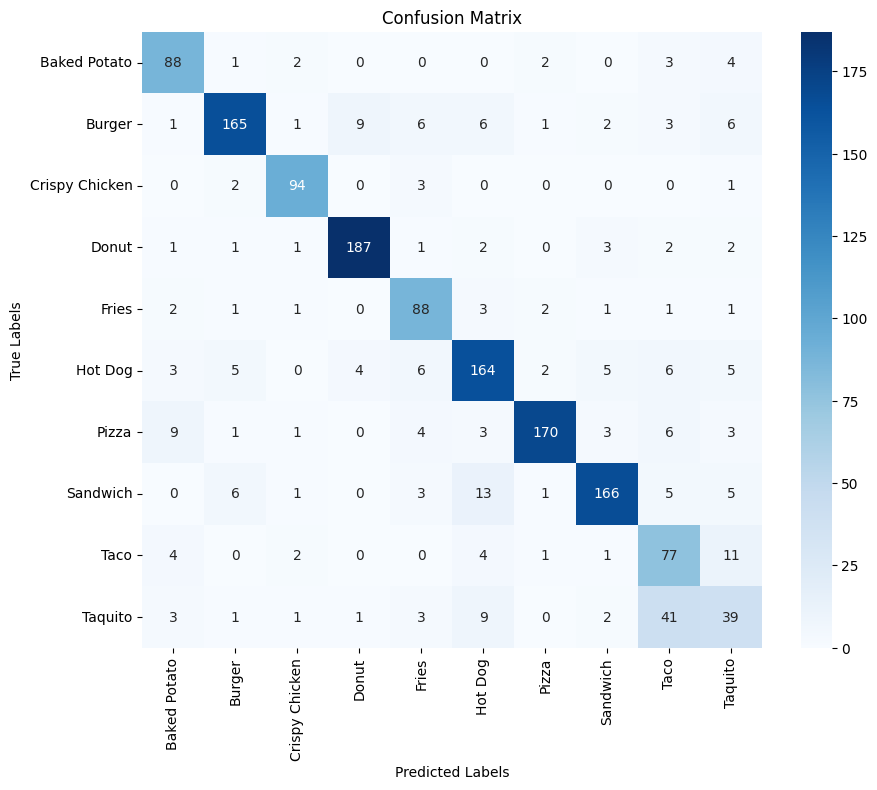

In [ ]:
# Calculate confusion matrix
cm = confusion_matrix(true_labels, predictions)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=test_dataset.class_names, yticklabels=test_dataset.class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()